# Code Overview
We'll try and explain what we can here...

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np
import pickle
from prediction_pipeline.model_shap_explainer import build_explainer

plt.style.use('https://pltstyle.s3.eu-west-1.amazonaws.com/zinc.mplstyle')
plt.rcParams["font.family"] = "DM Mono"

In [4]:
with open('data/model/ridge_position_stats.pkl', 'rb') as f:
    model_ridge_stats = pickle.load(f)

ridge_x_test = pd.read_csv('data/intermediate/model_ridge__position__x_test.csv')
#ridge_train_stats = pd.read_csv('../data/output/ridge_position_stats.csv')

try:
    ridge_x_test.drop(columns=['Unnamed: 0'], inplace=True)
    #reg_x_test.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    print(f'{ridge_x_test.shape[1]} columns in test set. No unnamed column')
except Exception as e:
    print(f'Some other error: {e}')
    pass
    

In [5]:
# Model loads for the supervised regression
with open('data/model/gradient_boosted_model.pkl', 'rb') as f:
    model_gbr = pickle.load(f)

with open('data/model/random_forest_model.pkl', 'rb') as f:
    model_rfr = pickle.load(f)


In [6]:
# Specify our regression training and test set for SHAP
roof_dict = {
   'outdoors': 1,
   'dome': 2,
   'retractable roof (closed)': 3,
   'retractable roof (open)': 4
}
reg_x_train = pd.read_csv('data/intermediate/model_rfr__x_train.csv')
reg_x_test = pd.read_csv('data/intermediate/model_rfr__x_test.csv')
reg_x_train['roof_type'] = reg_x_train['roof_type'].map(roof_dict.get)

try:
    reg_x_test.drop(columns=['Unnamed: 0'], inplace=True)
except KeyError:
    print(f'{reg_x_test.shape[1]} columns in test set. No "Unnamed: 0" column')
except Exception as e:
    print(f'Some other error: {e}')
    pass

14 columns in test set. No "Unnamed: 0" column


# SHAP Regression Explanation
## Explaining Weights for the Player Stats (Ridge Regression)

The player ranking alogorithm is made up of reading in all the different stats that are recorded in `PlayerStats`. This is fit using the years 2013-2014 (inclusive). In doing so, we are able to able to generate weights appropriate to then rank players afterwards.

By exposing the test and training data, we can better understand how the model views different features of importance through the use of `SHAP`.

We'll first read in the model via `shap.LinearExplainer`. 

In [7]:
explainer = shap.LinearExplainer(model_ridge_stats, ridge_x_test)
shap_values = explainer(ridge_x_test)
print(f'Shape of our data: {ridge_x_test.shape}')

Shape of our data: (132, 73)


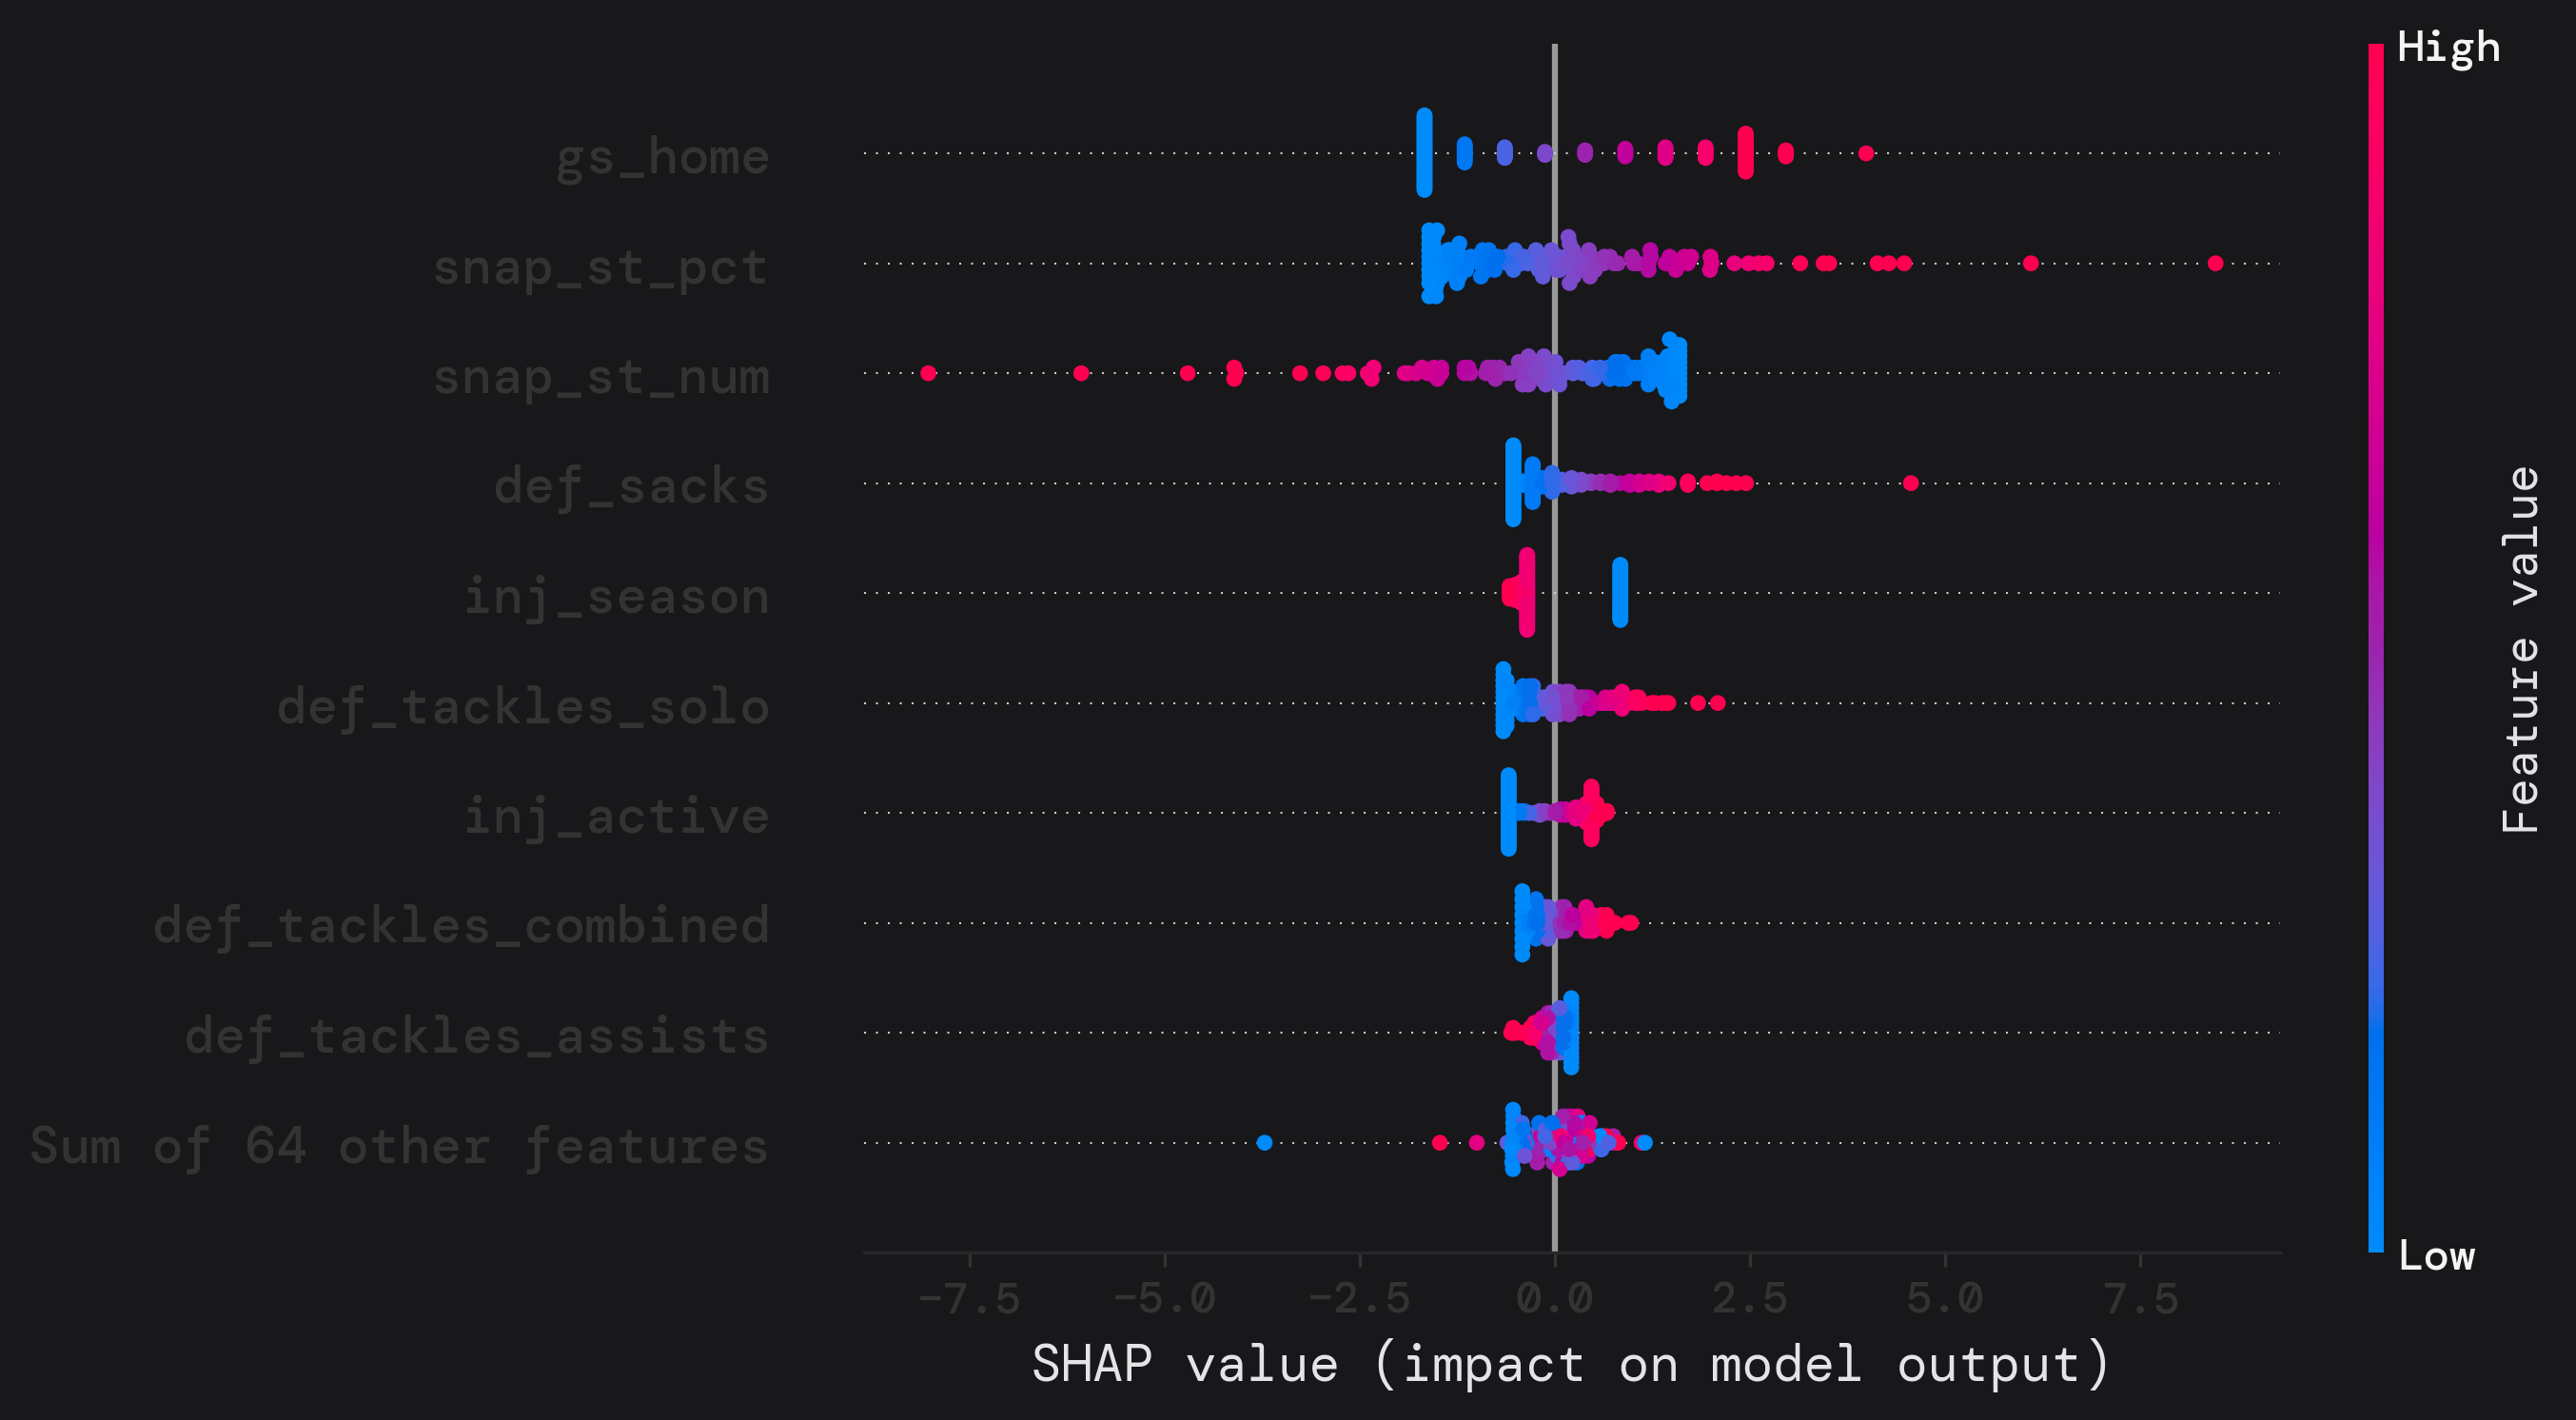

In [8]:
# Overall impact on the final values
shap.plots.beeswarm(shap_values)

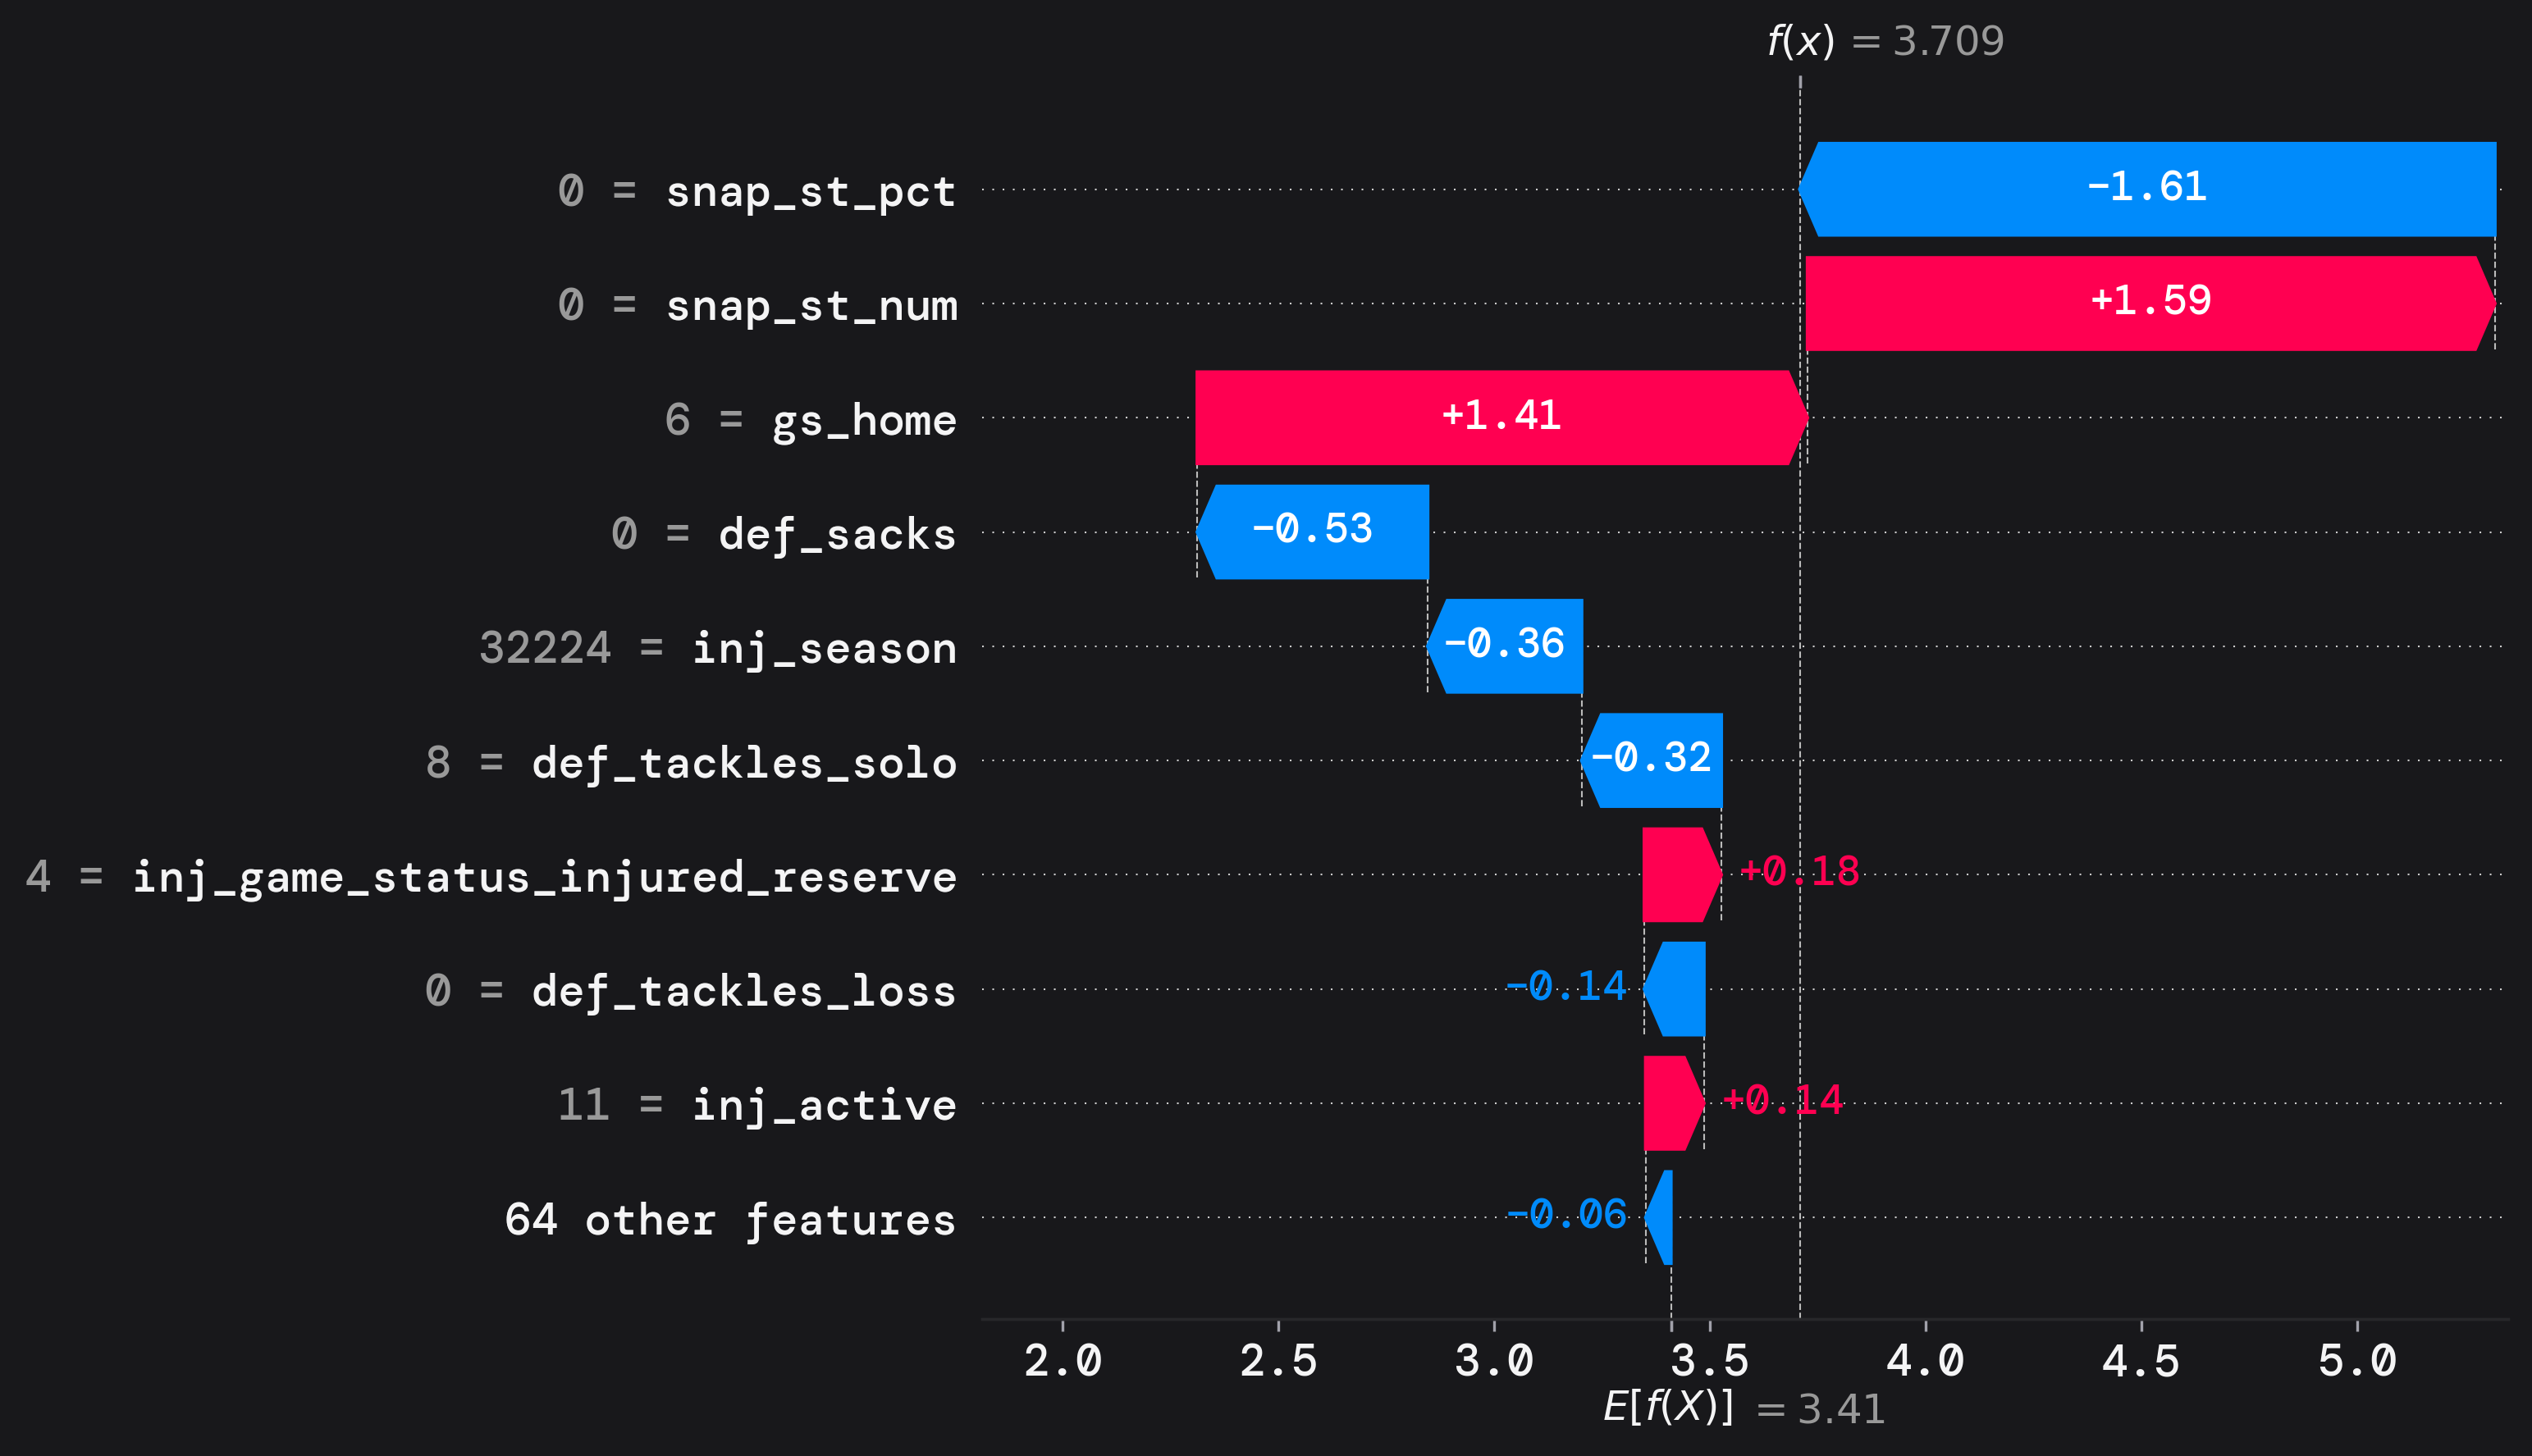

In [9]:
shap.plots.waterfall(shap_values[42])

In [10]:
# Random Forest Explainer
rfr_explainer = build_explainer(model_rfr.best_estimator_['regressor'])
rfr_shap_values = rfr_explainer.shap_values(np.array(reg_x_train.sample(100)), check_additivity=False)


In [10]:
# This is to print the JS visualization code to the notebook
shap.initjs()
#shap.plots.beeswarm(rfr_shap_values

In [11]:
rfr_results = pd.read_csv('data/output/random_forest_model_output.csv')

In [12]:
# Adding in some evaluation metrics
def game_outcome(team_a_score: float, team_b_score: float) -> str:
    """Compares the home team's score against the opponents
    Returns either a 'w' or a 'l'
    """
    if team_a_score > team_b_score:
        return "w"
    elif team_b_score > team_a_score:
        return "l"
    else:
        return "t"
    

rfr_results['home_result_actual'] = rfr_results[['score_home_test', 'score_opp_test']].apply(lambda row: game_outcome(row['score_home_test'], row['score_opp_test']), axis=1)
rfr_results['opp_results_actual'] = rfr_results[['score_opp_test', 'score_home_test']].apply(lambda row: game_outcome(row['score_opp_test'], row['score_home_test']), axis=1)
rfr_results['home_results_pred'] = rfr_results[['score_home_pred', 'score_opp_pred']].apply(lambda row: game_outcome(row['score_home_pred'], row['score_opp_pred']), axis=1)
rfr_results['opp_results_pred'] = rfr_results[['score_opp_pred', 'score_home_pred']].apply(lambda row: game_outcome(row['score_opp_pred'], row['score_home_pred']), axis=1)

rfr_results['spread_actual'] = rfr_results['score_home_test'] - rfr_results['score_opp_test']
rfr_results['spread_pred'] = rfr_results['score_home_pred'] - rfr_results['score_opp_pred']
rfr_results['home__abs_residual'] = abs(rfr_results['score_home_test'] - rfr_results['score_home_pred'])
rfr_results['opp__abs_residual'] = abs(rfr_results['score_opp_test'] - rfr_results['score_opp_pred'])
rfr_results['home__game_mape'] = rfr_results['home__abs_residual']/rfr_results['score_home_test']
rfr_results['opp__game_mape'] = rfr_results['opp__abs_residual']/rfr_results['score_opp_test']

rfr_results.head()

,Unnamed: 0,game_id,boxscore_stub,week_ind,day_int,OT,away,attendance,roof_type,humidity_pct,...,home_result_actual,opp_results_actual,home_results_pred,opp_results_pred,spread_actual,spread_pred,home__abs_residual,opp__abs_residual,home__game_mape,opp__game_mape
0,2173,nyj_buf_2023-09-11,/boxscores/202309110nyj.htm,1.0,1,1,1,83345.0,outdoors,88.0,...,w,l,l,w,6.0,-9.774,5.864,9.910,0.266545,0.619375
1,2174,buf_rai_2023-09-17,/boxscores/202309170buf.htm,2.0,2,0,0,70772.0,outdoors,57.0,...,w,l,w,l,28.0,14.866,12.601,0.533,0.331605,0.053300
2,2175,was_buf_2023-09-24,/boxscores/202309240was.htm,3.0,2,0,1,64291.0,outdoors,96.0,...,l,w,l,w,-34.0,-3.256,15.541,15.203,5.180333,0.410892
3,2176,buf_mia_2023-10-01,/boxscores/202310010buf.htm,4.0,2,0,0,70881.0,outdoors,71.0,...,w,l,w,l,28.0,5.106,19.271,3.623,0.401479,0.181150
4,2177,buf_jax_2023-10-08,/boxscores/202310080buf.htm,5.0,2,0,0,61273.0,outdoors,52.0,...,l,w,l,w,-5.0,-0.410,4.829,0.239,0.241450,0.009560


<Axes: xlabel='home_strength', ylabel='opp_strength'>

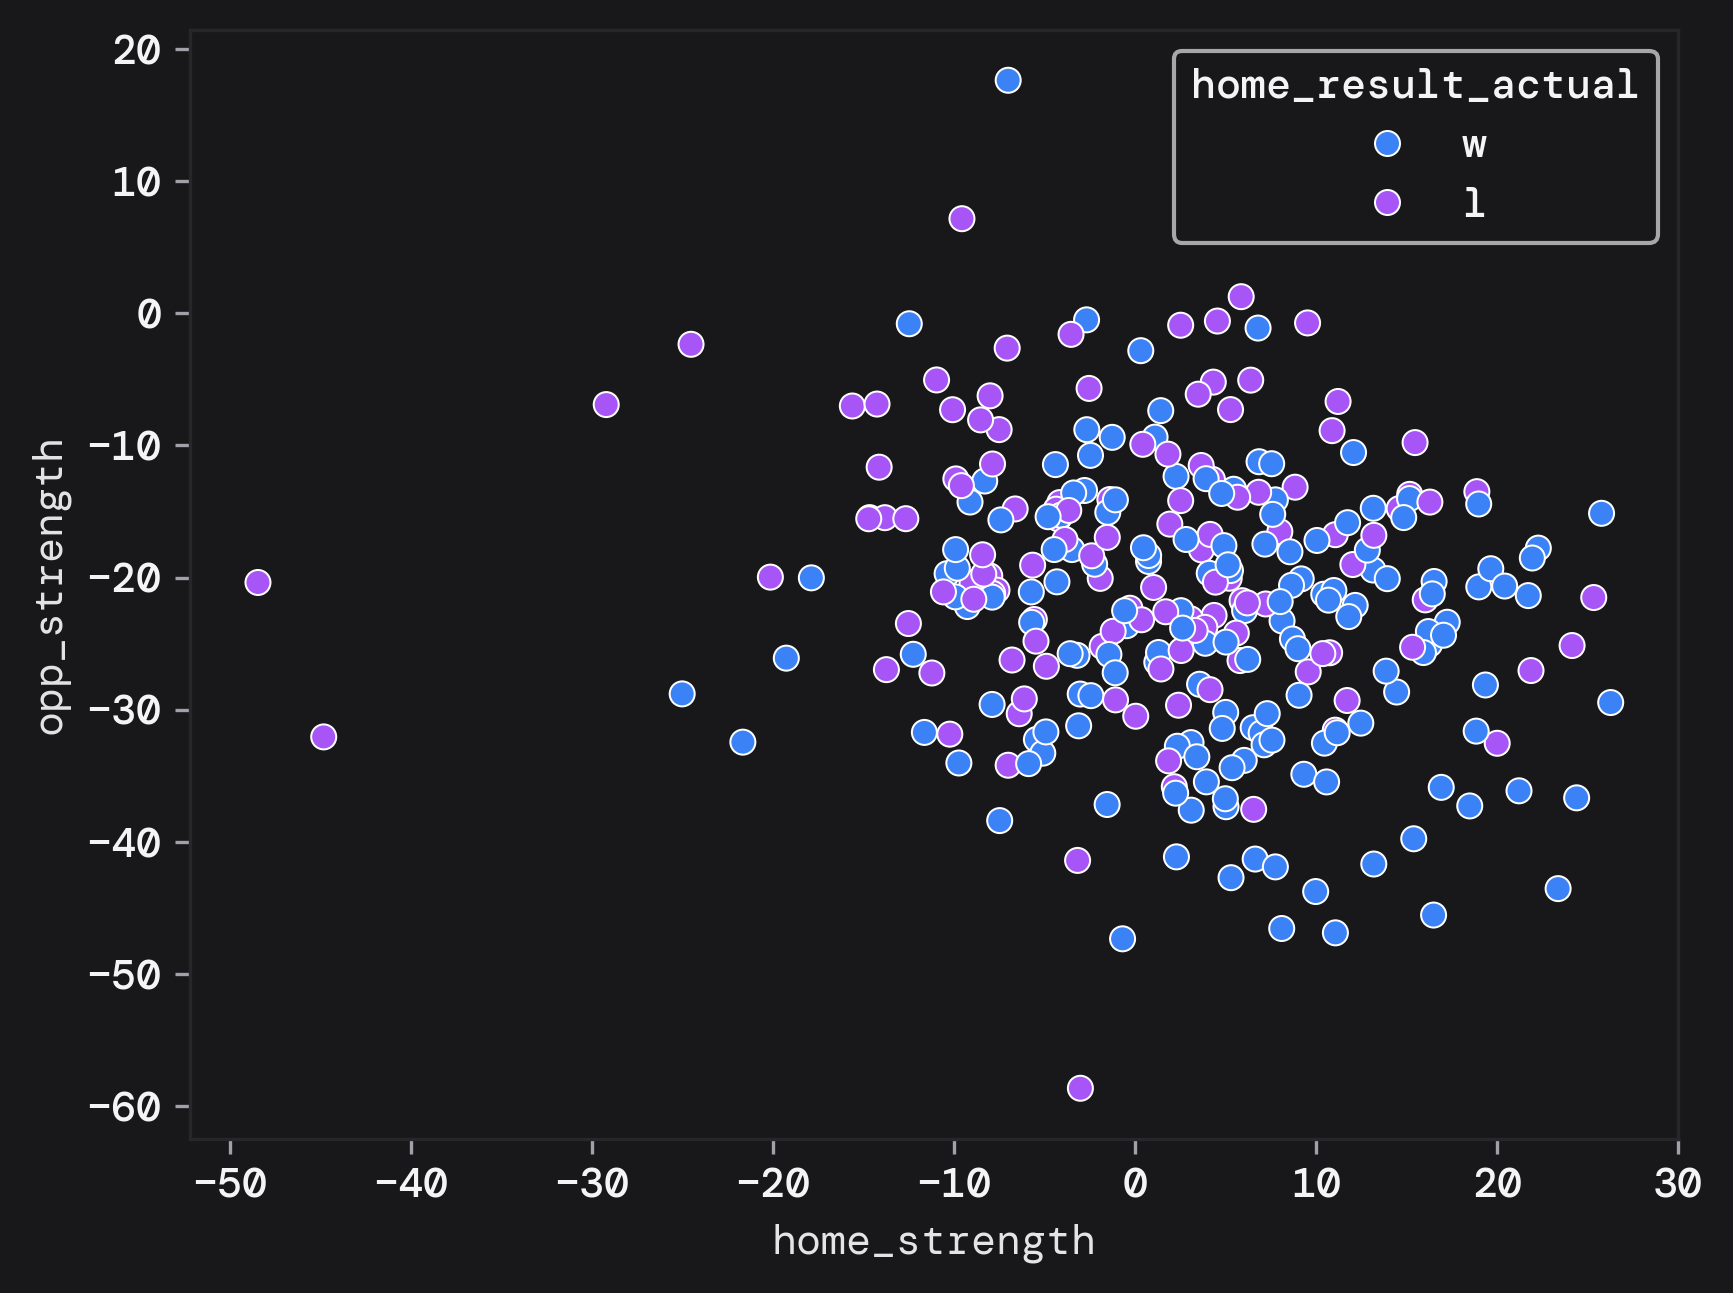

In [13]:
#sns.set_theme(style)

sns.scatterplot(data=rfr_results, x='home_strength', y = 'opp_strength', hue='home_result_actual')

<Axes: xlabel='home_strength', ylabel='score_home_test'>

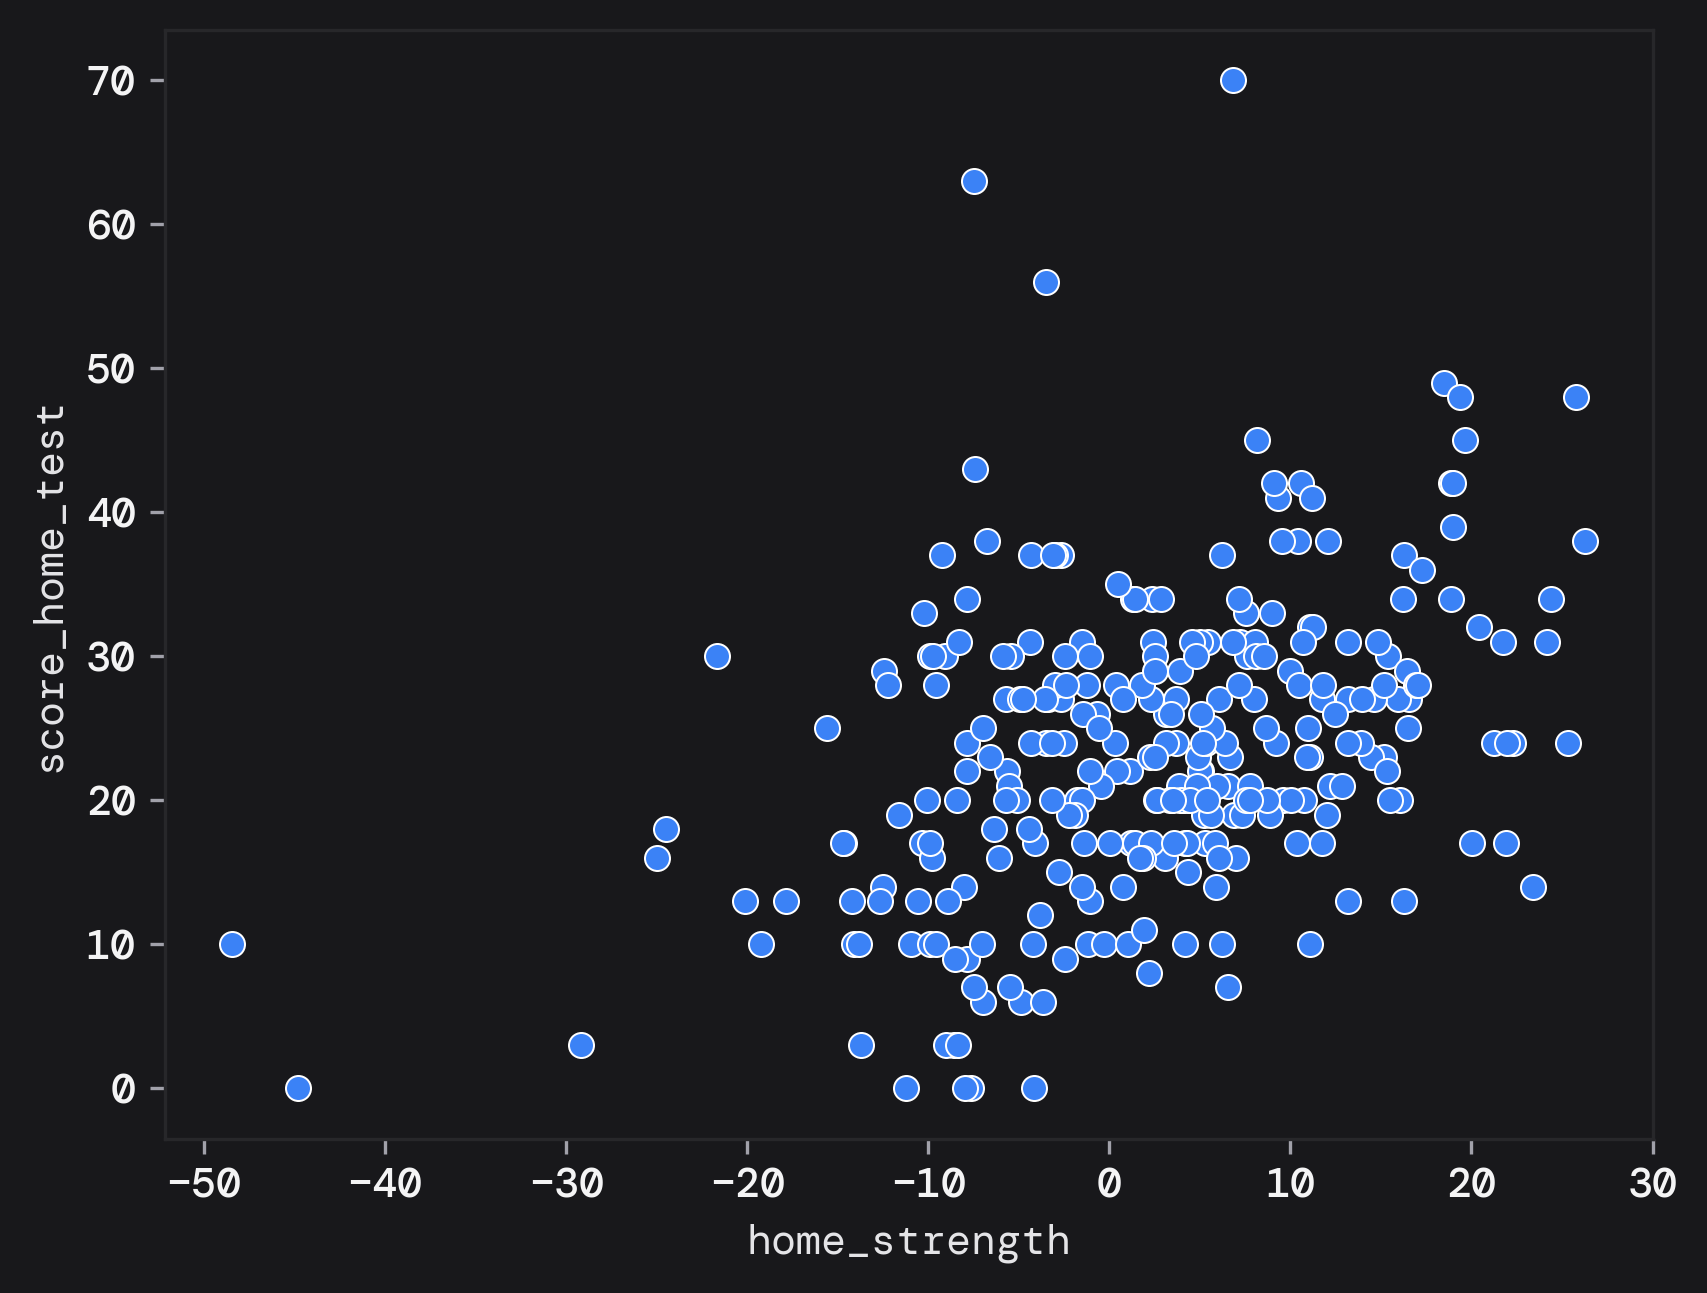

In [15]:
sns.scatterplot(data=rfr_results, y='score_home_test', x = 'home_strength')